# ARMBench Object Detection and Segmentation using MaskRCNN

**Author:** [Pinak Jani](https://www.linkedin.com/in/pinak-jani/)<br>
**Date created:** 05/20/2023<br>
**Last modified:** 05/21/2023<br>
**Description:** Object Detection and Instance Segmentation using MaskRCNN for warehouse robot manipulation ARMBench Dataset.




## Introduction
This example shows the implementation of object detection and instance segmentation for ARMBench Dataset using MaskRCNN model in Pytorch. This example includes the process of data loading, data visualization and model training for the ARMBench segmentation data.



## Setup

In [ ]:
# Include Necessary Modules
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

## Download and Unzip ARMBench Dataset

The [ARMBench](http://armbench.s3-website-us-east-1.amazonaws.com/index.html) dataset download can be requested [here](http://armbench.s3-website-us-east-1.amazonaws.com/data.html).
In this example, I have already included the download link to the [Object Segmentation](http://armbench.s3-website-us-east-1.amazonaws.com/segmentation.html) dataset.

In [ ]:
# !wget https://armbench-dataset.s3.amazonaws.com/segmentation/armbench-segmentation-0.1.tar.gz
# !tar -xzf "/content/armbench-segmentation-0.1.tar.gz"

In [ ]:
# Print the size of data
print('Mix-tote-object Image Data' , len(os.listdir('./content/armbench-segmentation-0.1/mix-object-tote/images')))
print('Same-object-transfer Image Data' , len(os.listdir('./content/armbench-segmentation-0.1/same-object-transfer-set/images')))
print('Zoomed-out-tote Image Data' , len(os.listdir('./content/armbench-segmentation-0.1/zoomed-out-tote-transfer-set/images')))

Mix-tote-object Image Data 44251
Same-object-transfer Image Data 3323
Zoomed-out-tote Image Data 5837


In my example I will train and test my model with mix-object-tote data.

In [ ]:
mix_object_path = os.listdir('./content/armbench-segmentation-0.1/mix-object-tote/images')

## Create your ARMBench Dataset Class

In Pytorch it is straight-forward to use built-in datasets, however it may become challenging to use your own custom data in a particular format.

PyTorch has the DataLoader and Dataset classes that can be modified for our application.


Most datasets for object detection and segmentation are in COCO format. The ARMBench Segmentation dataset is also in COCO format. However, the official tutorial does not explicitly mention the use of COCO format.

Here is an implementation of a creating a custom dataset class for COCO format.

In [ ]:
class ARMBench(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        #  List: get cat id from coco
        cat_ids = coco.getCatIds()
        # print(cat_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))
        # create mask
        mask = np.stack([np.where(coco.annToMask(ann)>0,1,0) for ann in coco_annotation])
        # number of objects in the image
        num_objs = len(coco_annotation)
        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        areas = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(coco_annotation[i]['category_id'])
            areas.append(coco_annotation[i]['area'])

        # Reshape Mask and convert to uint8 type
        masks = mask.transpose((1,2,0))
        # Tensorize Bbox
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I have two classes: Tote class and Object class)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        # Apply transforms
        if self.transforms is not None:
            img = self.transforms(img)
            masks = self.transforms(masks)

        my_annotation["masks"] = masks

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [ ]:
# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

Create a train and test dataloader using our ARMBench dataset class.

In [ ]:
# path to your own data and coco file
train_data_dir = './content/armbench-segmentation-0.1/mix-object-tote/images'
train_armbench = './content/armbench-segmentation-0.1/mix-object-tote/train.json'
test_armbench = './content/armbench-segmentation-0.1/mix-object-tote/test.json'

# create own Dataset
train_dataset = ARMBench(root=train_data_dir,
                          annotation=train_armbench,
                          transforms=get_transform())

test_dataset = ARMBench(root=train_data_dir,
                          annotation=test_armbench,
                          transforms=get_transform())

# Sample 10,000 random indices from the original dataset
random_indices = random.sample(range(len(train_dataset)),100)

# Create a subset of the original dataset using the sampled indices
train_subset = torch.utils.data.Subset(train_dataset, random_indices)



# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 1
test_batch_size = 1

# train and test DataLoader
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=test_batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=5.75s)
creating index...
index created!
loading annotations into memory...
Done (t=1.37s)
creating index...
index created!


In [ ]:
print(len(train_dataloader),len(test_dataloader))


30992 6605


## Visualize dataset with annotations

Now that we have developed our dataloaders for training. Let's visualize them to verify and have better understanding of our dataset.



In [ ]:
# Query a random set of images using iterator of dataloader
images,labels = next(iter(train_dataloader))

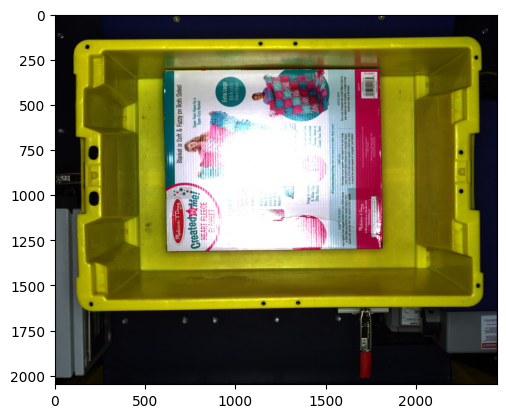

In [ ]:
# Display a random image from train_dataloader
plt.imshow(images[0].numpy().transpose(1,2,0))


In [ ]:
# This function creates random colors for our masks
def random_color_masks(image):
  # I will copy a list of colors here
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

# This function does the preprocessing for linking masks with their label names
def preprocess(img,pred,threshold=0.5):
  # print(pred[0]['labels'])
  INSTANCE_CATEGORY_NAMES = ["Tote","Object"]
  masks = (pred[0]['masks'] ==True).squeeze().detach().cpu().numpy()
  pred_class = [INSTANCE_CATEGORY_NAMES[i-1] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  return masks, pred_boxes, pred_class

# This function helps in visualizing the image with annotation
def vis_segmentation(images,labels, threshold=0.9, rect_th=3,
                          text_size=3, text_th=3, url=False):
  masks, boxes, pred_cls = preprocess(images,labels,threshold=threshold)
  img = images[0].numpy().transpose(1,2,0)
  img = img*255
  img = img.astype(np.uint8)
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 1)
    pt1 = tuple(int(x) for x in boxes[i][0])
    pt2 = tuple(int(x) for x in boxes[i][1])
    cv2.rectangle(img, pt1, pt2, color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img, pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  return img, pred_cls, masks[1]


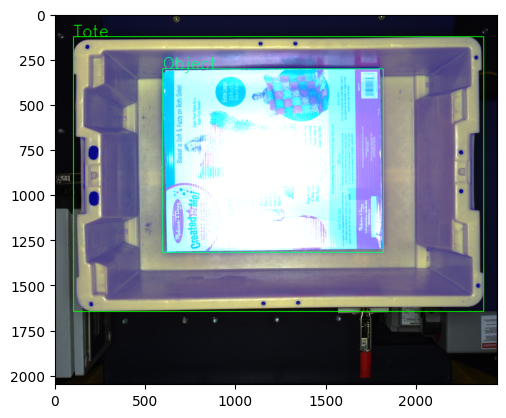

In [ ]:
out,cls,instances = vis_segmentation(images,labels)
plt.imshow(out)

## Create Model and Train the model

In [ ]:
# Use GPU for training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Create a MaskRCNN model using pretrained weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Modify the model with input class and replace the multi-head for bbox and mask prediction
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
from tqdm import tqdm
# 3 classes, i.e 0: Background, 1: Tote, 2: Object
num_classes = 3
# Train for one epoch
num_epochs = 1
model = get_model_instance_segmentation(num_classes)
# move model to the right device
model.to(device)
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# Print length of dataloader
len_dataloader = len(train_dataloader)
print(len_dataloader)
# Begin Training
for epoch in tqdm(range(num_epochs)):
    model.train()
    i = 0
    for imgs, annotations in train_dataloader:
        i += 1
        torch.cuda.empty_cache()
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        torch.cuda.empty_cache()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


30992


  0%|          | 0/1 [00:00<?, ?it/s]

Iteration: 1/30992, Loss: 8.09337329864502
Iteration: 2/30992, Loss: 3.289400577545166
Iteration: 3/30992, Loss: 1.944754958152771
Iteration: 4/30992, Loss: 0.9061837792396545
Iteration: 5/30992, Loss: 2.953045129776001
Iteration: 6/30992, Loss: 1.6179025173187256
Iteration: 7/30992, Loss: 3.639291524887085
Iteration: 8/30992, Loss: 1.3745510578155518
Iteration: 9/30992, Loss: 1.1595542430877686
Iteration: 10/30992, Loss: 1.2356510162353516
Iteration: 11/30992, Loss: 1.0242210626602173
Iteration: 12/30992, Loss: 1.3828619718551636
Iteration: 13/30992, Loss: 1.4605234861373901
Iteration: 14/30992, Loss: 2.0927748680114746
Iteration: 15/30992, Loss: 3.1713204383850098
Iteration: 16/30992, Loss: 0.7028403878211975
Iteration: 17/30992, Loss: 1.3695549964904785
Iteration: 18/30992, Loss: 2.344510555267334
Iteration: 19/30992, Loss: 1.3577024936676025
Iteration: 20/30992, Loss: 0.8954498171806335
Iteration: 21/30992, Loss: 1.459245204925537
Iteration: 22/30992, Loss: 1.2001075744628906
Itera

100%|██████████| 1/1 [6:31:20<00:00, 23480.07s/it]

Iteration: 30992/30992, Loss: 0.05321725085377693


In [ ]:
# Specify path to save model
PATH = "model.pt"
# Save Model
torch.save(model, PATH)

In [ ]:
# Download model on local computer
# from google.colab import files
# download(PATH)

## Custom Prediction using trained model

The following script helps in making custom predictions of object bounding box, object class and segments.



In [ ]:
def get_prediction(img_path, model, threshold=0.5, url=False):

  INSTANCE_CATEGORY_NAMES = ["Tote","Object"]
  img = Image.open(img_path) # This is for local images
  transform = get_transform()
  img = transform(img)
  img = img.cuda() # Only if GPU, otherwise comment this line
  pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
  #Let's change it to GPU
  # pred = pred.cpu() # We will just send predictions back to CPU
  # Now we need to extract the bounding boxes and masks
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] >0.5).squeeze().detach().cpu().numpy()
  pred_class = [INSTANCE_CATEGORY_NAMES[i-1] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [ ]:
def instance_segmentation(img_path, model, threshold=0.9, rect_th=3,
                          text_size=3, text_th=3, url=False):
  # Make predictions using the image input the threshlod
  masks, boxes, pred_cls = get_prediction(img_path, model, threshold=threshold, url=url)
  # Load the image from the path
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
  # Add bounding box and instance colors on the image
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.8, 0)
    pt1 = tuple(int(x) for x in boxes[i][0])
    pt2 = tuple(int(x) for x in boxes[i][1])
    cv2.rectangle(img, pt1, pt2, color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img, pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  return img, pred_cls, masks[i]

In [ ]:
# This function helps in adding random colors as instance masks
def random_color_masks(image):
  # I will copy a list of colors here
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

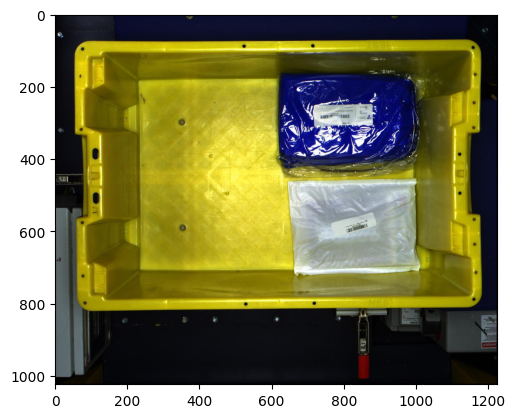

In [ ]:
input_img = Image.open("test.jpg")
plt.imshow(input_img)

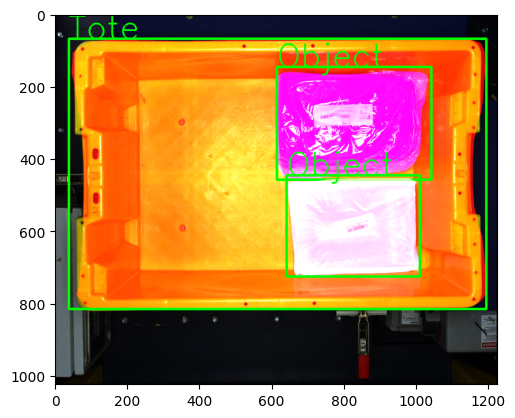

In [ ]:
# Change model to testing mode
model.eval()
# Here use your path of a custom image instead of test.jpg
img, pred_classes, masks = instance_segmentation('test.jpg', model, rect_th=5, text_th=4)
plt.imshow(img)

In [ ]:
from tqdm.notebook import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
# Set the model to evaluation mode
model.eval()
# Define the device (CPU or GPU) to use
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
# Create a COCO instance of Dataset for evaluation
coco_gt = COCO(test_armbench)  # Replace 'path/to/annotations.json' with the path to your COCO annotations file

# Define the list to store COCO-style results
coco_results = []

# Iterate over the test dataset and evaluate the model
for images, targets in tqdm(test_dataloader):
    torch.cuda.empty_cache()
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # Forward pass
    outputs = model(images)

    # Post-processing: Get the predicted bounding boxes, labels, and scores
    pred_boxes = outputs[0]['boxes'].cpu().detach()
    pred_labels = outputs[0]['labels'].cpu().detach()
    pred_scores = outputs[0]['scores'].cpu().detach()

    # Convert the predicted boxes, labels, and scores to COCO format
    image_id = targets[0]['image_id'].item()
    coco_results.extend([
        {'image_id': image_id, 'category_id': pred_labels[i].item(), 'bbox': pred_boxes[i].tolist(), 'score': pred_scores[i].item()}
        for i in range(len(pred_boxes))
    ])

# Load the results into COCO evaluation API
coco_dt = coco_gt.loadRes(coco_results)

# Run the COCO evaluation
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Get the mAP score
mAP = coco_eval.stats[0]

# Print the mAP score
print(f"mAP: {mAP}")


loading annotations into memory...
Done (t=0.94s)
creating index...
index created!


  0%|          | 0/6605 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from tqdm.notebook import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Set the model to evaluation mode
model.eval()

# Define the device (CPU or GPU) to use
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

# Create a COCO instance for evaluation
coco_gt = COCO(test_armbench)  # Replace 'path/to/annotations.json' with the path to your COCO annotations file

# Define the list to store COCO-style results
coco_results = []

# Iterate over the test dataset and evaluate the model
for images, targets in tqdm(test_dataloader):
    torch.cuda.empty_cache()
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # Forward pass
    outputs = model(images)

    # Post-processing: Get the predicted bounding boxes, labels, and scores
    pred_boxes = outputs[0]['boxes'].cpu().detach()
    pred_labels = outputs[0]['labels'].cpu().detach()
    pred_scores = outputs[0]['scores'].cpu().detach()
    pred_masks = (outputs[0]['masks'] > 0.5).squeeze().cpu().detach().numpy()


    pred_masks = np.uint8(pred_masks)
    for i in range(len(pred_labels)):
        mask = pred_masks[i]
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        segmentation = []
        for contour in contours:
            contour = contour.flatten().tolist()
            if len(contour) > 4:
                segmentation.append(contour)
        coco_results.append({
            'image_id': targets[0]['image_id'].item(),
            'category_id': pred_labels[i].item(),
            'segmentation': segmentation,
            'score': pred_scores[i].item()
        })

# Load the results into COCO evaluation API
coco_dt = coco_gt.loadRes(coco_results)

# Run the COCO evaluation
coco_eval = COCOeval(coco_gt, coco_dt, iouType= 'segm')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Get the mAP score
mAP = coco_eval.stats[0]

# Print the mAP score
print(f"mAP: {mAP}")


## References


* ARMBench: An Object-centric Benchmark Dataset for Robotic Manipulation [Paper](https://arxiv.org/pdf/2303.16382.pdf)
* Mask R-CNN [Paper](https://arxiv.org/pdf/1703.06870.pdf)
* How to train an Object Detector with your own COCO dataset in PyTorch blog by Takashi Nakamura -  [Medium Blog](https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5)
* Pytorch Segmentation Tutorial [Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)
* Instance Segmentation with PyTorch and Mask R-CNN [Blog](https://debuggercafe.com/instance-segmentation-with-pytorch-and-mask-r-cnn/)



